In [1]:
from tsai.all import *
import sklearn.metrics as skm

from IPython.display import clear_output
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [2]:
# Read the data
data = pd.read_csv('final_processed.csv', index_col=0)

data.tail()

level_0      index     unixTimes  accelerometerX  accelerometerY  \
9181496  18362992  1310204.5  1.648124e+12        -2192.50          159.75   
9181497  18362994  1310206.5  1.648124e+12        -2194.00          163.75   
9181498  18362996  1310208.5  1.648124e+12        -2193.75          167.00   
9181499  18362998  1310210.5  1.648124e+12        -2192.00          161.50   
9181500  18363000  1310212.5  1.648124e+12        -2187.25          163.00   

         accelerometerZ  gyroscopeX  gyroscopeY  gyroscopeZ   ledGreen  ...  \
9181496         3402.00       14.25     -199.25       61.50 -38.178333  ...   
9181497         3395.50       19.75     -201.00       57.75 -29.258338  ...   
9181498         3394.75       17.00     -222.25       58.00 -18.186857  ...   
9181499         3398.00       22.75     -246.75       54.00  -7.657366  ...   
9181500         3402.00       25.00     -237.25       58.50   0.566843  ...   

               sdsd       rmssd     pnn20     pnn50 hr_mad         sd1  \
9181496         NaN         NaN       NaN       NaN    NaN         NaN   
9181497         NaN         NaN       NaN       NaN    NaN         NaN   
9181498         NaN         NaN       NaN       NaN    NaN         NaN   
9181499         NaN         NaN       NaN       NaN    NaN         NaN   
9181500  134.366369  222.843576  0.888889  0.777778   80.0  157.351188   

                sd2             s   sd1/sd2  breathingrate  
9181496         NaN           NaN       NaN            NaN  
9181497         NaN           NaN       NaN            NaN  
9181498         NaN           NaN       NaN            NaN  
9181499         NaN           NaN       NaN            NaN  
9181500  119.835278  59238.572803  1.313062        0.20436  

[5 rows x 24 columns]

In [3]:
df = data.copy()

df = df[df.sleep_state != -1]

# Binary Classification
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)

# fill NaN values
df = df.fillna(method='bfill', limit=1500).dropna()

# # set column time as datetime index
# df['time'] = pd.to_datetime(df['time'])
# df = df.set_index('time', drop=True)

df = df[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]


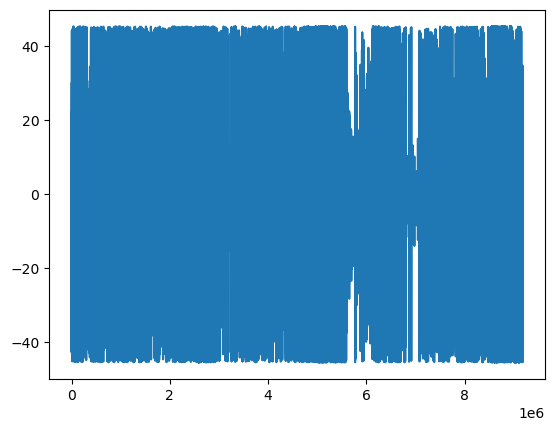

In [4]:
# df = ((df + df.shift(-1)) / 2)[::2]

# remove extreme values from the signal (outliers)


def remove_extreme_values(signal, threshold):
    # Compute the absolute difference between the signal and its mean
    absolute_difference = np.abs(signal - np.mean(signal))
    # Compute the median of the absolute difference
    median_absolute_difference = np.median(absolute_difference)
    # Compute the median absolute deviation
    median_absolute_deviation = 1.4826 * median_absolute_difference
    # Compute the z-score
    z_score = 0.6745 * (absolute_difference / median_absolute_deviation)
    # Remove the extreme values
    signal = signal[z_score < threshold]
    return signal


# Example usage
filtered_ppg = remove_extreme_values(df['ledGreen'], threshold=3.0)
filtered_bpm = remove_extreme_values(df['bpm'], threshold=3.0)
filtered_rmssd = remove_extreme_values(df['rmssd'], threshold=3.0)
filtered_pnn20 = remove_extreme_values(df['pnn20'], threshold=3.0)
filtered_pnn50 = remove_extreme_values(df['pnn50'], threshold=3.0)
filtered_hr_mad = remove_extreme_values(df['hr_mad'], threshold=3.0)
filtered_sd1 = remove_extreme_values(df['sd1'], threshold=3.0)
filtered_sd2 = remove_extreme_values(df['sd2'], threshold=3.0)
filtered_accelerometerX = remove_extreme_values(df['accelerometerX'], threshold=3.0)
filtered_accelerometerY = remove_extreme_values(df['accelerometerY'], threshold=3.0)
filtered_accelerometerZ = remove_extreme_values(df['accelerometerZ'], threshold=3.0)
filtered_gyroscopeX = remove_extreme_values(df['gyroscopeX'], threshold=3.0)
filtered_gyroscopeY = remove_extreme_values(df['gyroscopeY'], threshold=3.0)
filtered_gyroscopeZ = remove_extreme_values(df['gyroscopeZ'], threshold=3.0)


df['ledGreen'] = filtered_ppg
df['bpm'] = filtered_bpm
df['rmssd'] = filtered_rmssd
df['pnn20'] = filtered_pnn20
df['pnn50'] = filtered_pnn50
df['hr_mad'] = filtered_hr_mad
df['sd1'] = filtered_sd1
df['sd2'] = filtered_sd2
df['accelerometerX'] = filtered_accelerometerX
df['accelerometerY'] = filtered_accelerometerY
df['accelerometerZ'] = filtered_accelerometerZ
df['gyroscopeX'] = filtered_gyroscopeX
df['gyroscopeY'] = filtered_gyroscopeY
df['gyroscopeZ'] = filtered_gyroscopeZ

df = df.dropna()

plt.plot(filtered_ppg)

In [5]:
# Non null values in the dataset
df.isnull().sum()

ledGreen          0
bpm               0
rmssd             0
pnn20             0
pnn50             0
hr_mad            0
sd1               0
sd2               0
accelerometerX    0
accelerometerY    0
accelerometerZ    0
gyroscopeX        0
gyroscopeY        0
gyroscopeZ        0
sleep_state       0
dtype: int64

In [6]:
class_map = {
    0: 'WK',  # wake
    1: 'SL',  # sleep
}
class_map

{0: 'WK', 1: 'SL'}

<AxesSubplot:>

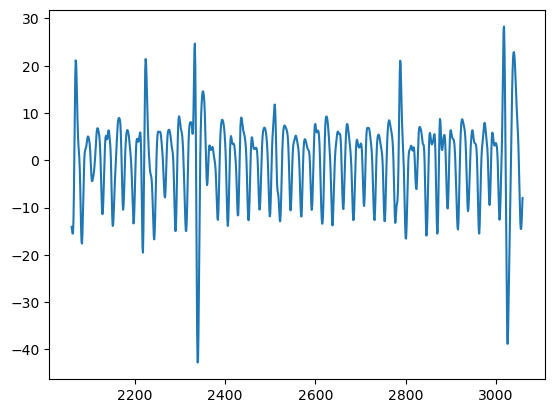

In [7]:
df['ledGreen'][2000:3000].plot()

# Filters and transforms

## TSData preparation

## Data from 3d array

In [8]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder


scaler = StandardScaler()
le = LabelEncoder()

temp_df = df[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]
X = scaler.fit_transform(temp_df.drop('sleep_state', axis=1))
y = le.fit_transform(temp_df['sleep_state'])

# selecting sequences range
X = X[0:(len(X) - len(X) % 1500)]
y = y[0:(len(y) - len(y) % 1500)]

# reshape the data to tsai format
X = X.reshape(-1, 1500, 14)
X = X.transpose(0, 2, 1)
y = y.reshape(-1, 1500)
y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

print(X.shape, y.shape)

pd.DataFrame(X[0])

(4130, 14, 1500) (4130,)


0         1         2         3         4         5         6     \
0   3.511098 -3.441734  2.510957  1.654117 -0.513232 -2.508292 -3.363246   
1  -0.328731 -0.328731 -0.328731 -0.328731 -0.328731 -0.328731 -0.328731   
2   0.395687  0.395687  0.395687  0.395687  0.395687  0.395687  0.395687   
3   0.469685  0.469685  0.469685  0.469685  0.469685  0.469685  0.469685   
4   1.162858  1.162858  1.162858  1.162858  1.162858  1.162858  1.162858   
5   0.554867  0.554867  0.554867  0.554867  0.554867  0.554867  0.554867   
6   0.516931  0.516931  0.516931  0.516931  0.516931  0.516931  0.516931   
7   1.473752  1.473752  1.473752  1.473752  1.473752  1.473752  1.473752   
8  -0.870245 -0.878063 -0.871783 -0.877935 -0.876525 -0.876012 -0.887290   
9   0.553438  0.598086  0.581055  0.584738  0.591182  0.575072  0.589341   
10  1.516415  1.519533  1.518220  1.515266  1.517564  1.518876  1.520845   
11 -0.752070 -0.946809 -0.900278 -0.931298 -0.933022 -0.960595 -0.970935   
12  0.964015  0.401455  0.340165  0.631295  0.605027  0.598460  0.585327   
13  0.430928  1.206116  1.212419  1.206116  0.935116  0.701929  0.998139   

        7         8         9     ...      1490      1491      1492      1493  \
0  -2.677016 -2.020238 -1.440856  ... -0.025599 -0.259027 -0.459134 -0.610161   
1  -0.328731 -0.328731 -0.328731  ...  0.108858  0.108858  0.108858  0.108858   
2   0.395687  0.395687  0.395687  ...  1.730537  1.730537  1.730537  1.730537   
3   0.469685  0.469685  0.469685  ...  1.411216  1.411216  1.411216  1.411216   
4   1.162858  1.162858  1.162858  ...  1.299468  1.299468  1.299468  1.299468   
5   0.554867  0.554867  0.554867  ...  0.554867  0.554867  0.554867  0.554867   
6   0.516931  0.516931  0.516931  ...  1.877658  1.877658  1.877658  1.877658   
7   1.473752  1.473752  1.473752  ...  0.919860  0.919860  0.919860  0.919860   
8  -0.874603 -0.870886 -0.880113  ... -0.877550 -0.873193 -0.878832 -0.882548   
9   0.582897  0.552517  0.552057  ...  0.573691  0.575532  0.557120  0.543772   
10  1.519369  1.516497  1.517728  ...  1.519451  1.516743  1.518958  1.516661   
11 -1.039869 -0.965765 -0.907172  ... -0.938192 -0.955425 -1.043316 -1.077783   
12  0.292008  0.475879  0.504336  ...  0.519658  0.596272  0.620350  0.675074   
13  0.430928  0.865790  1.174605  ...  1.086372  0.412021  0.336393  0.878395   

        1494      1495      1496      1497      1498      1499  
0  -0.694336 -0.702821 -0.642530 -0.528596 -0.374784 -0.197798  
1   0.108858  0.108858  0.108858  0.108858  0.108858  0.108858  
2   1.730537  1.730537  1.730537  1.730537  1.730537  1.730537  
3   1.411216  1.411216  1.411216  1.411216  1.411216  1.411216  
4   1.299468  1.299468  1.299468  1.299468  1.299468  1.299468  
5   0.554867  0.554867  0.554867  0.554867  0.554867  0.554867  
6   1.877658  1.877658  1.877658  1.877658  1.877658  1.877658  
7   0.919860  0.919860  0.919860  0.919860  0.919860  0.919860  
8  -0.881651 -0.879601 -0.869861 -0.877550 -0.880754 -0.880498  
9   0.546994  0.585658  0.566786  0.549295  0.557580  0.566326  
10  1.517728  1.520517  1.516415  1.515676  1.518958  1.517317  
11 -1.031253 -1.127760 -1.067443 -0.998509 -1.036423 -1.034699  
12  0.826111  0.534981  0.615972  0.926803  0.731986  0.780143  
13  1.363675  1.401489  1.067465  0.985534  0.556975  0.292277  

[14 rows x 1500 columns]

In [9]:
# # Reverser X & y

# X = np.flip(X)
# y = np.flip(y)

# print(X.shape, y.shape)

In [10]:
# sht = len(X) // 1500
# print("Shape: ", sht)

# X = X.T.reshape(sht, 8, 1500)
# y = y.T.reshape(sht, 1500)
# y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

# X.shape, y.shape

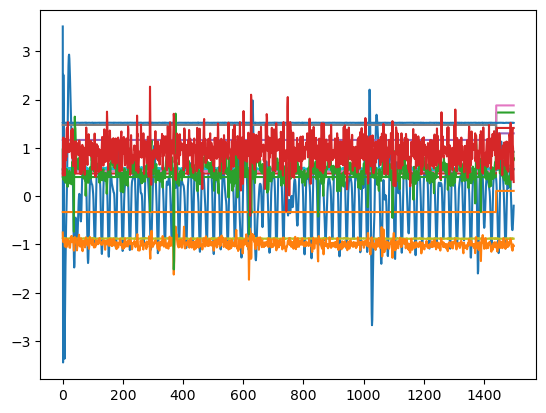

In [11]:
# plot the first 2 sequences
plt.plot(X[0].T)

In [12]:
labeler = ReLabeler(class_map)
new_y = labeler(y) # map to more descriptive labels

X.shape, new_y.shape

((4130, 14, 1500), (4130,))

In [13]:
label_counts = collections.Counter(new_y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'WK': 1346, 'SL': 2784}
Naive Accuracy: 67.41%


## Dataloaders

In [14]:
# metrics = [accuracy, Precision(), Recall(), F1Score()]

# model = build_ts_model(InceptionTimePlus, dls=dls, **{'fc_dropout' : 0.5})
# # model = build_ts_model(InceptionTimePlus, dls=dls)

# learn = ts_learner(dls, model, metrics=metrics, cbs=ShowGraph())

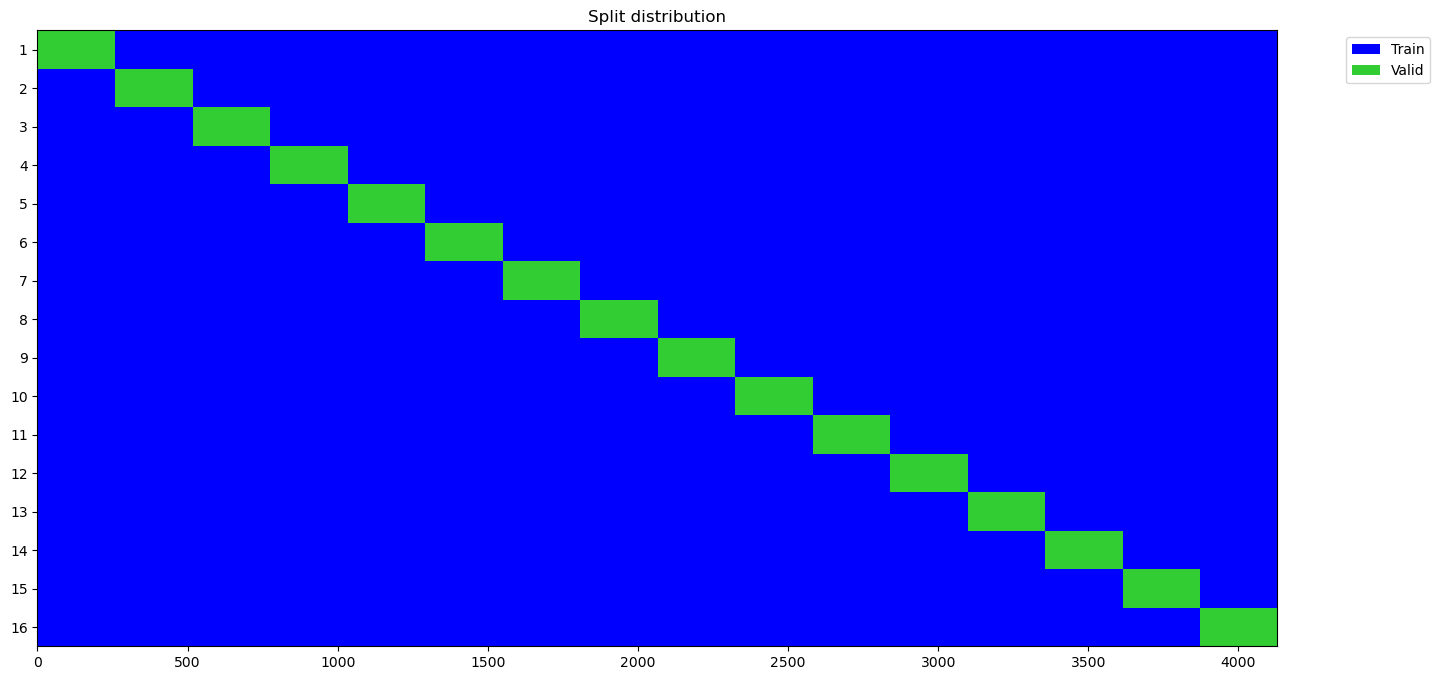

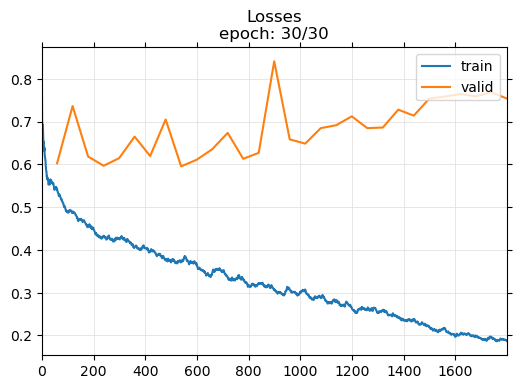

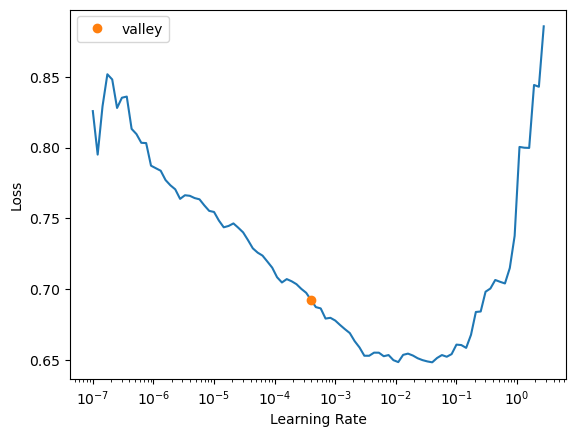

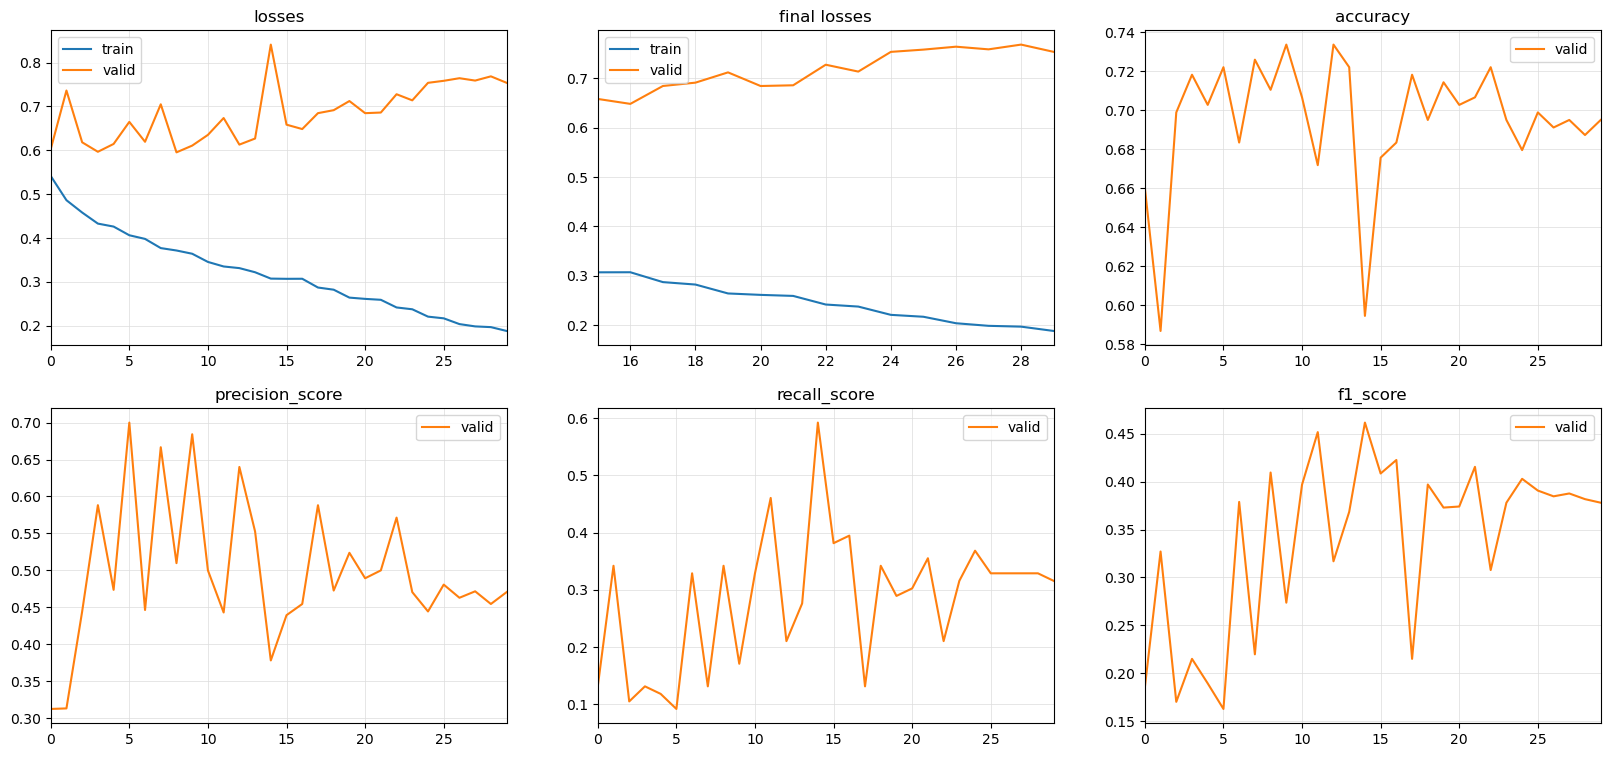

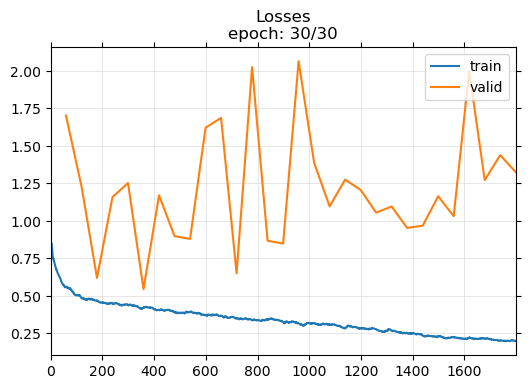

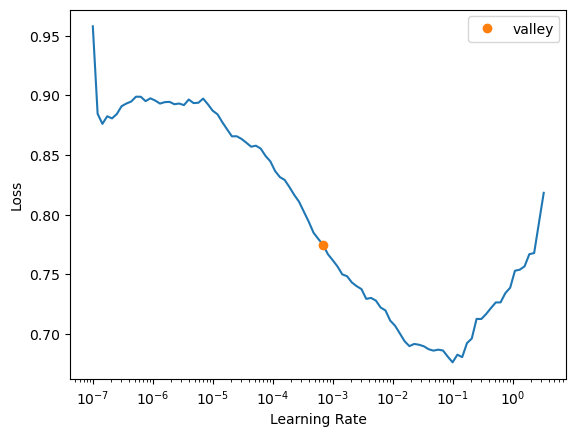

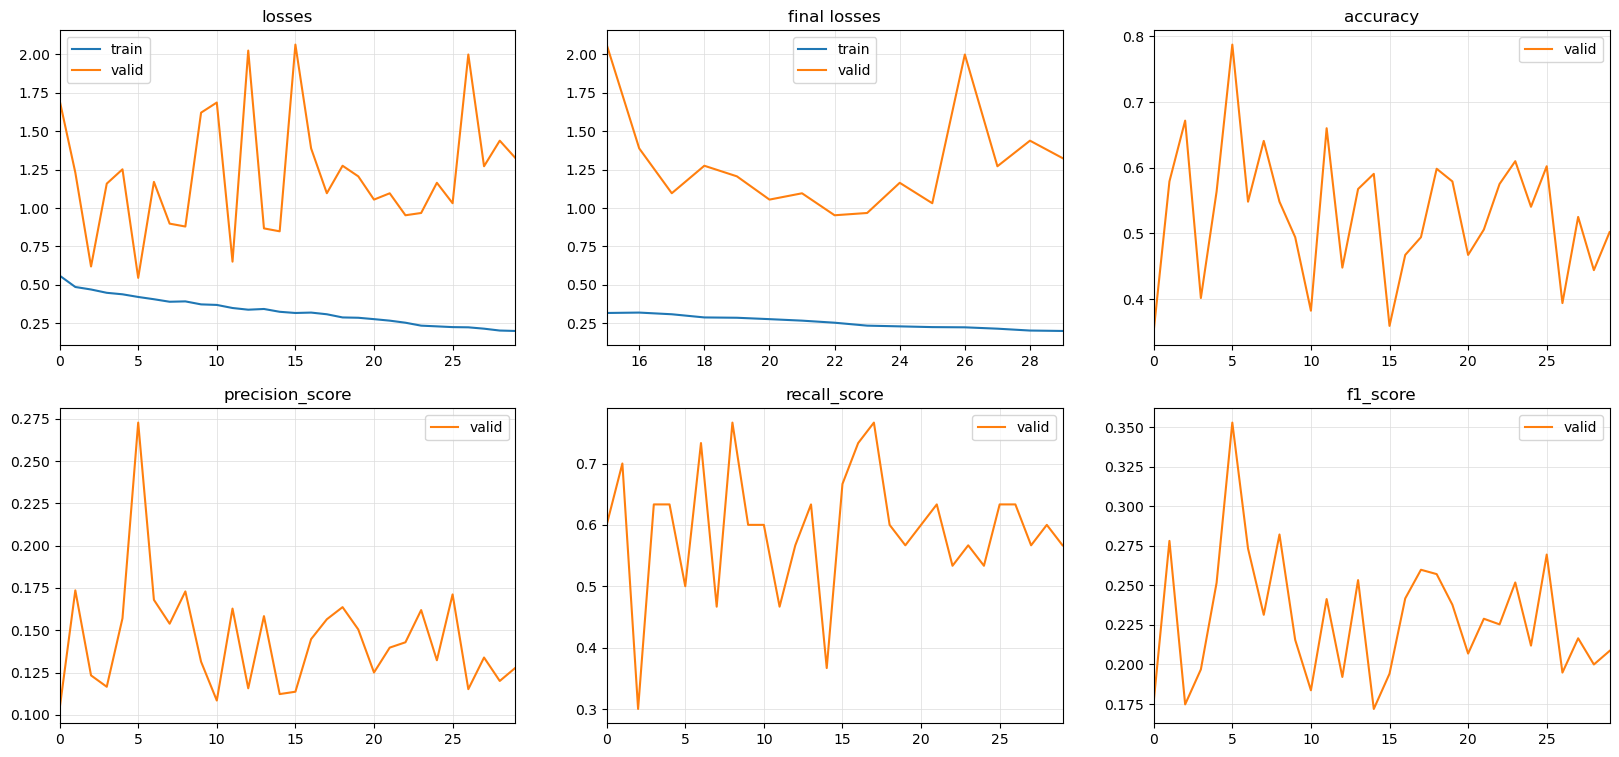

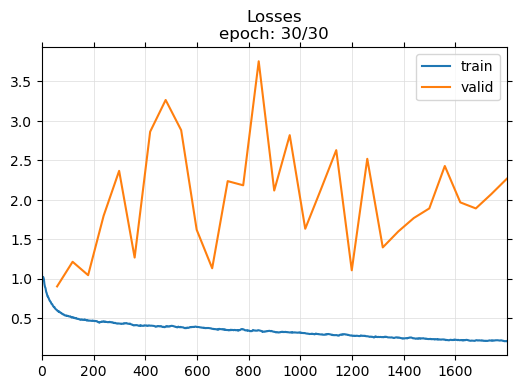

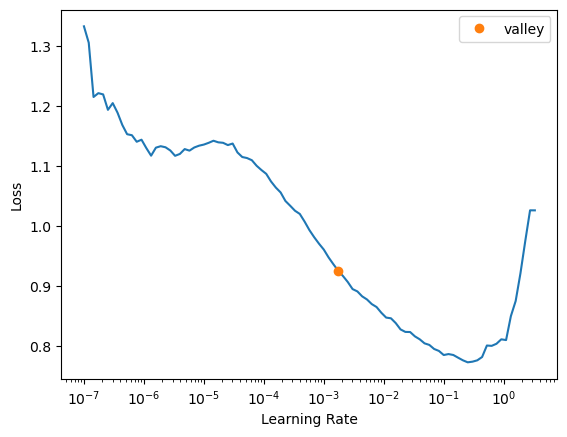

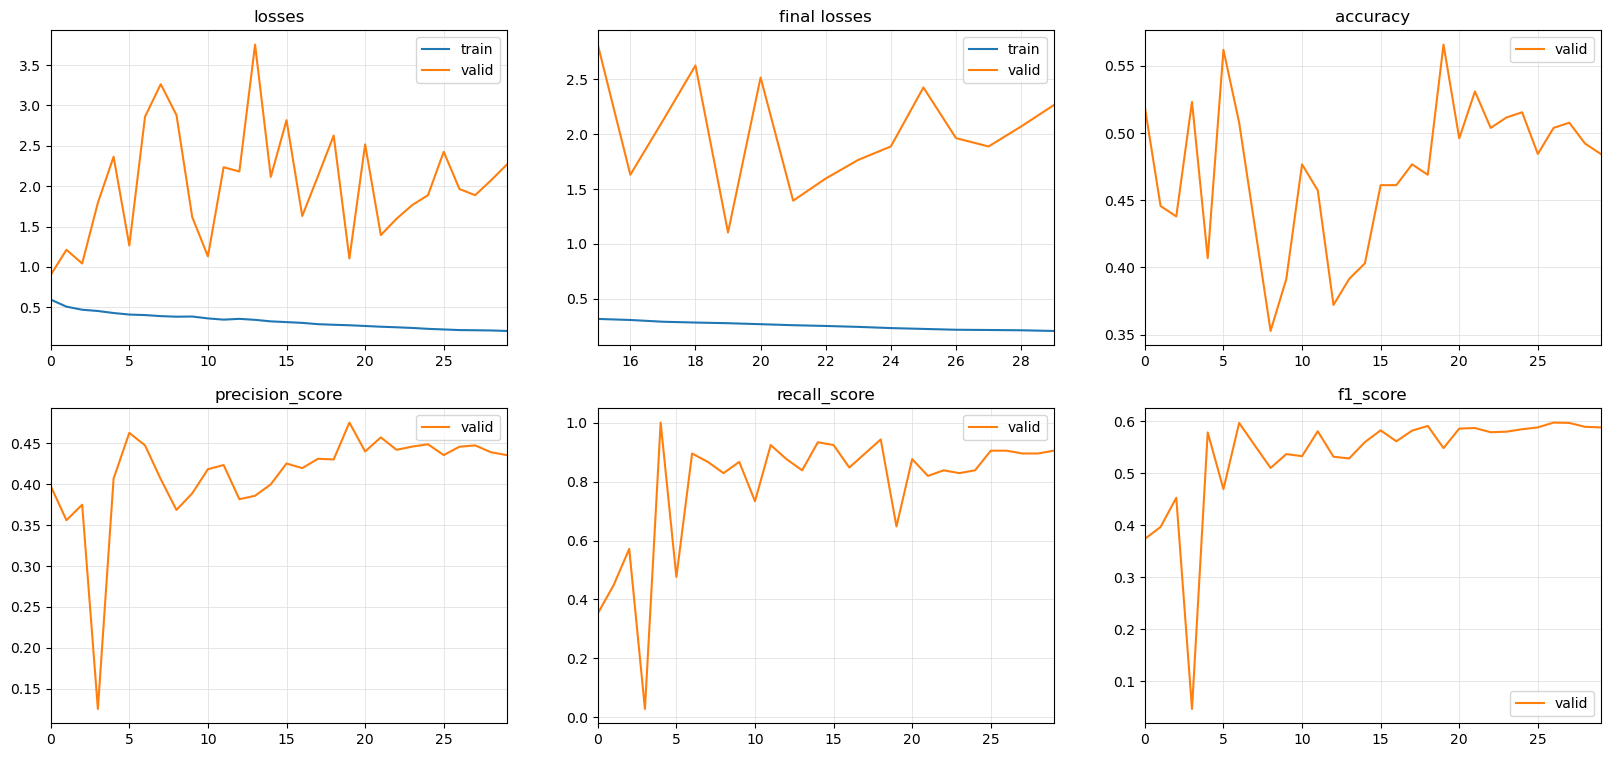

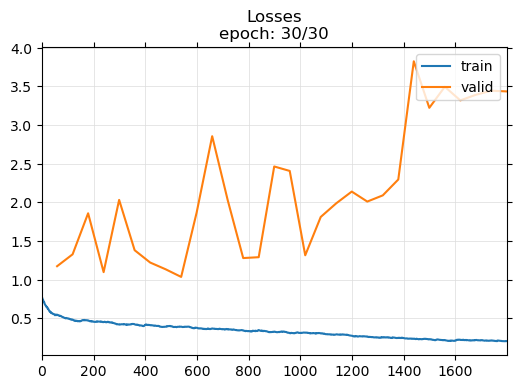

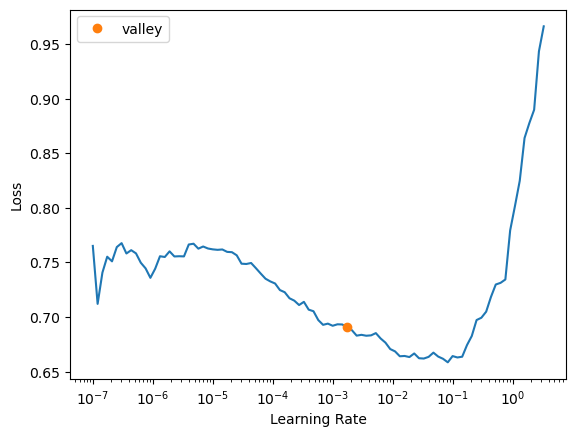

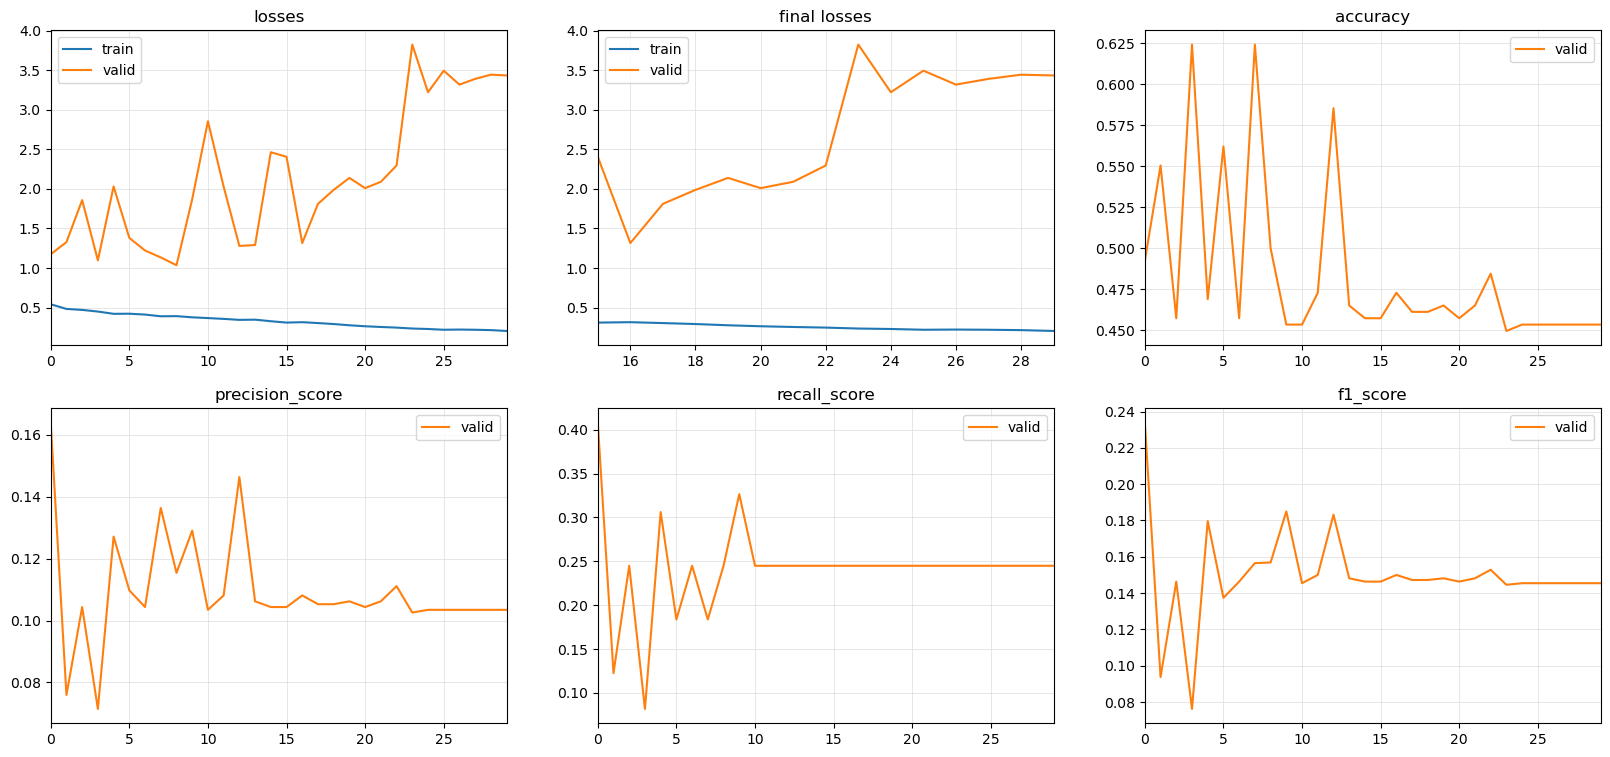

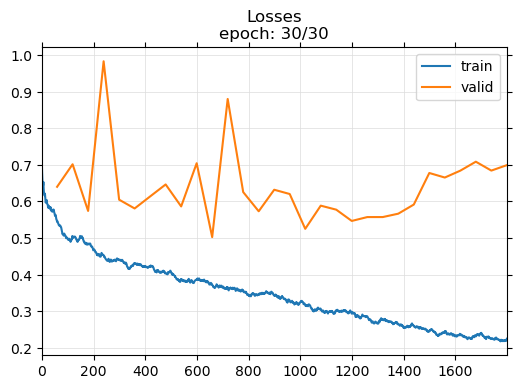

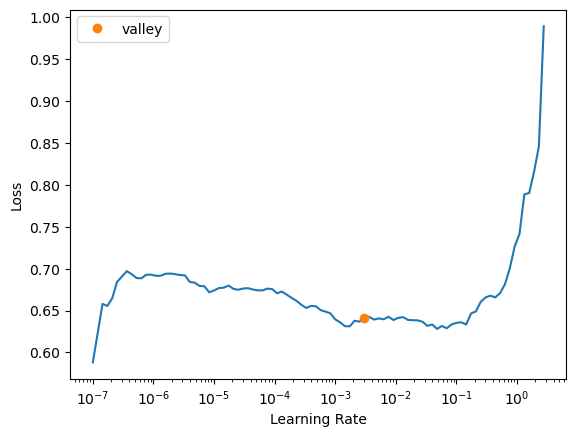

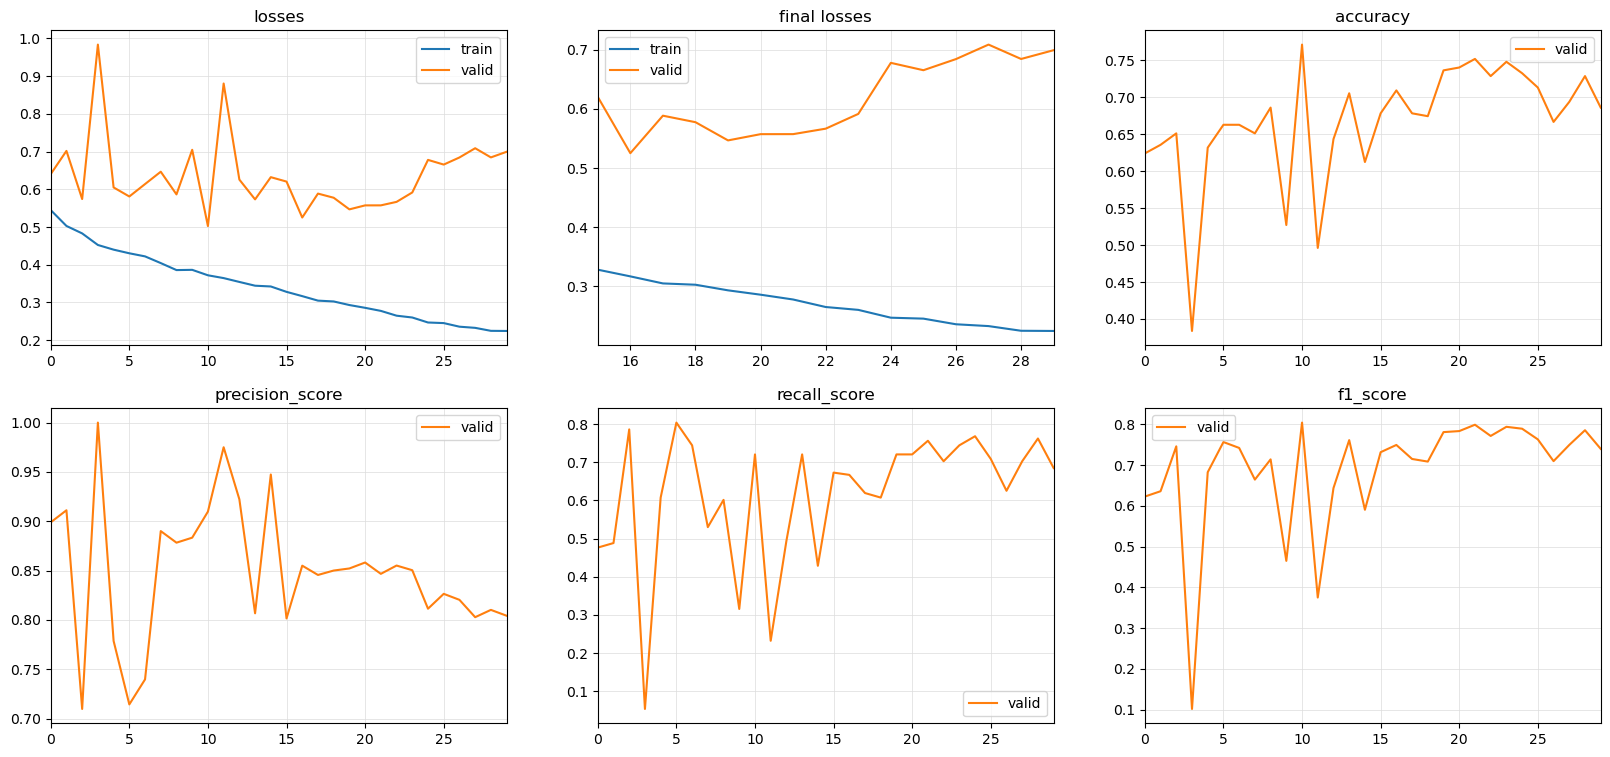

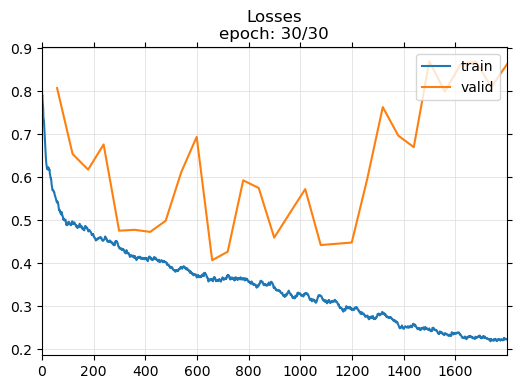

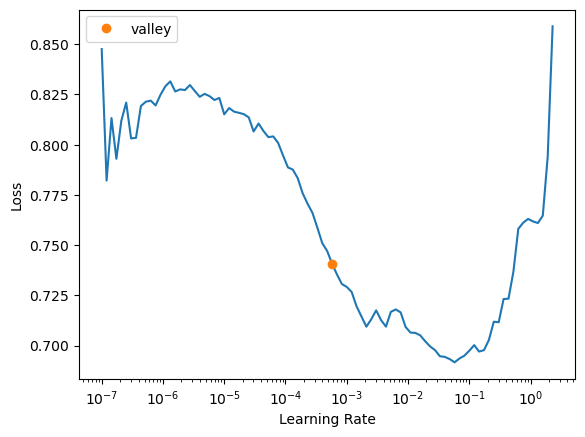

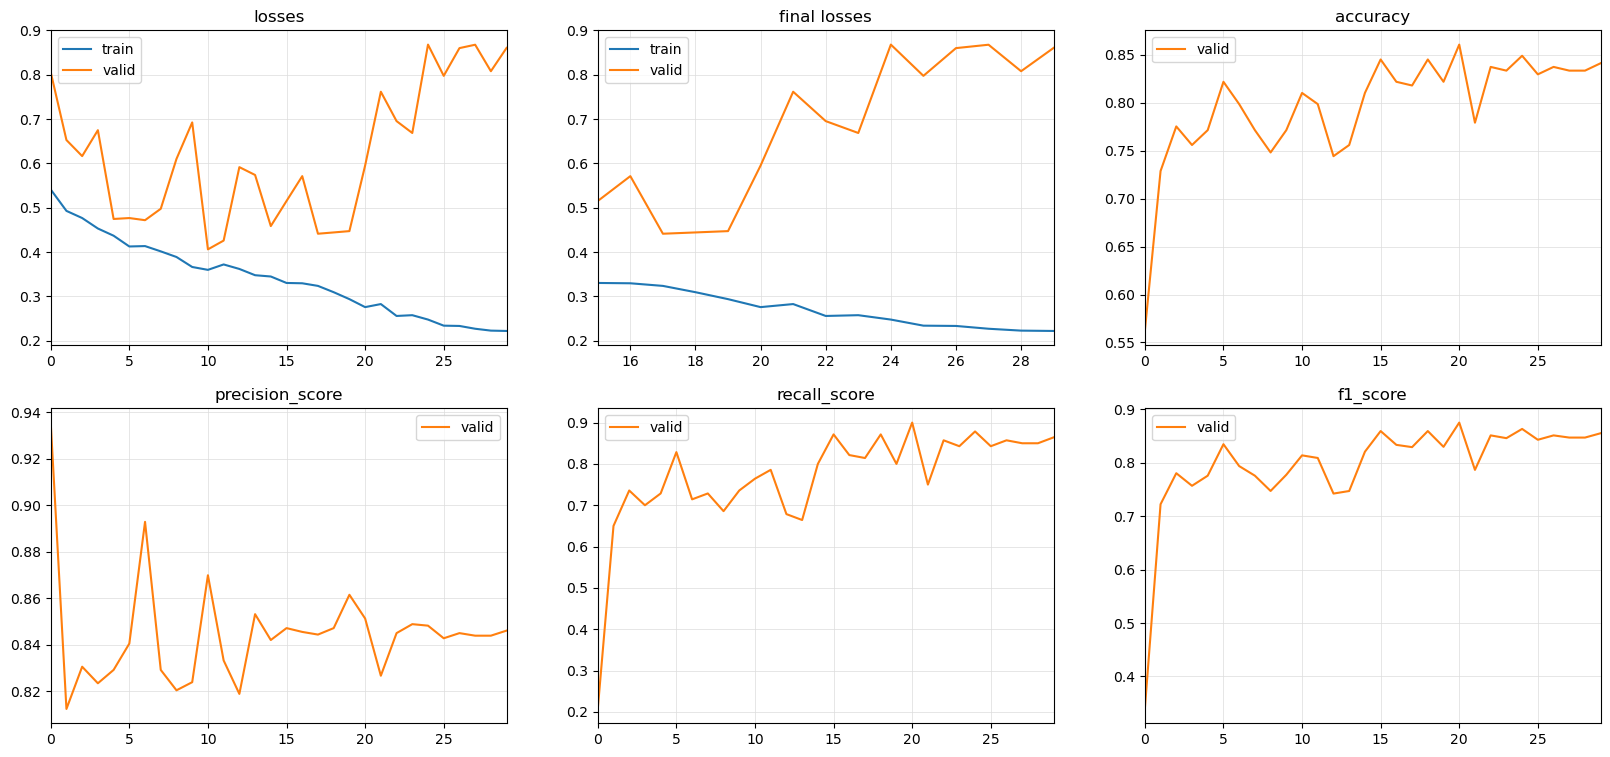

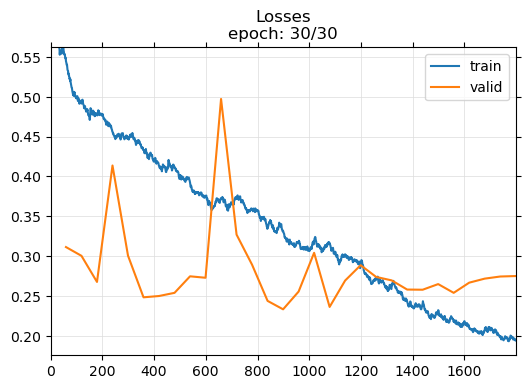

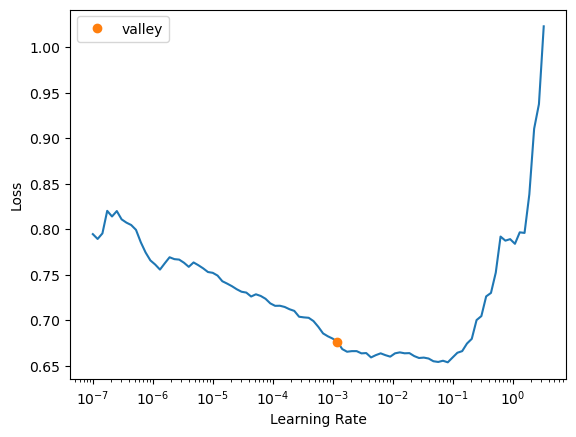

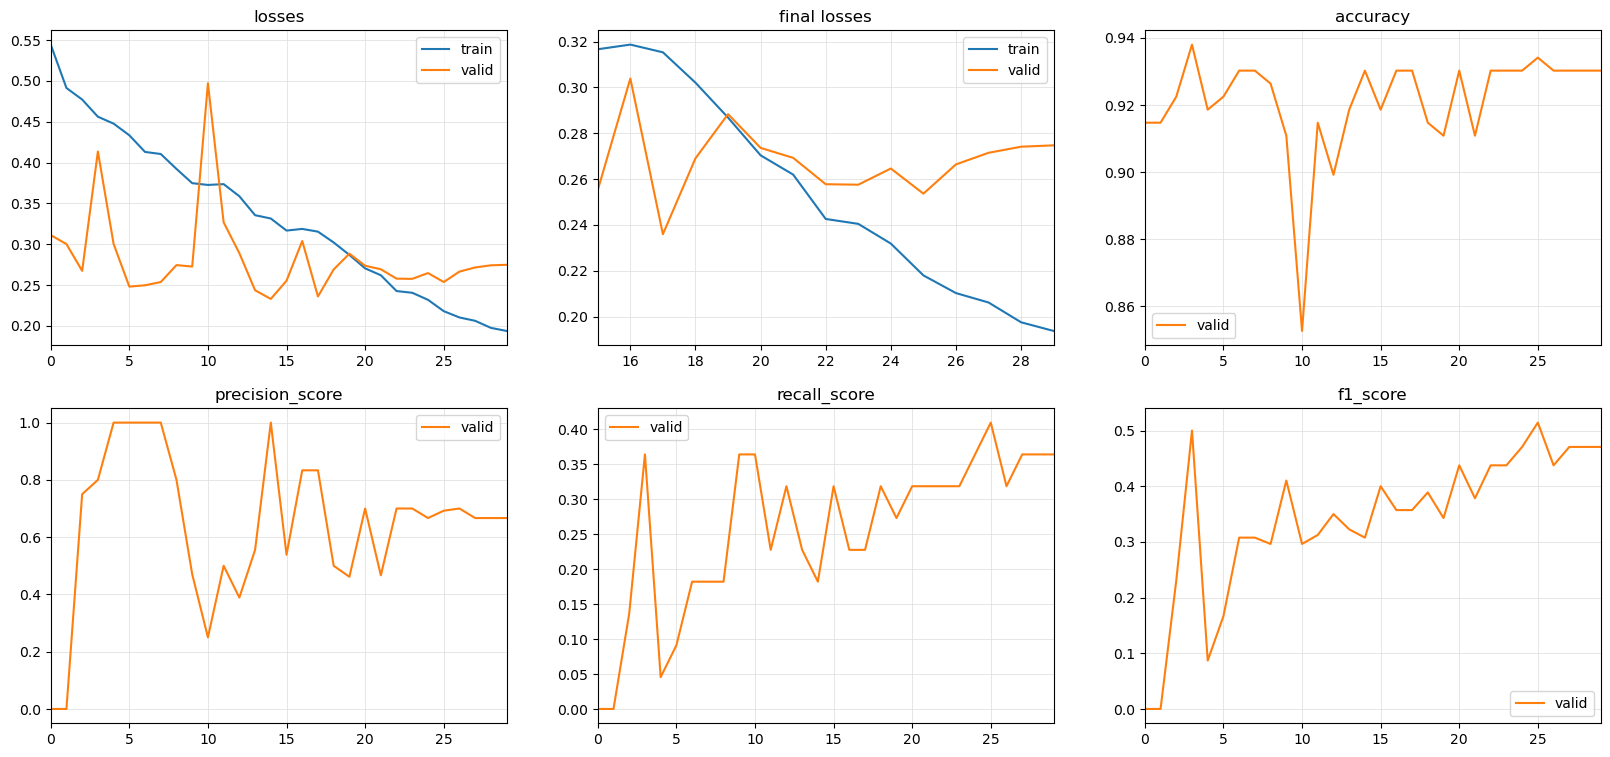

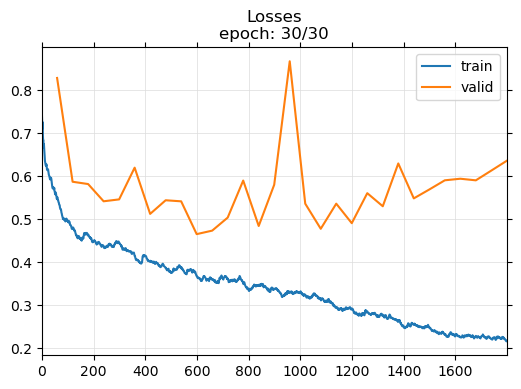

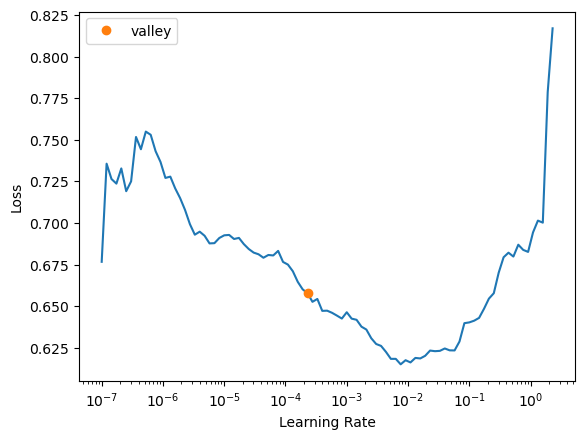

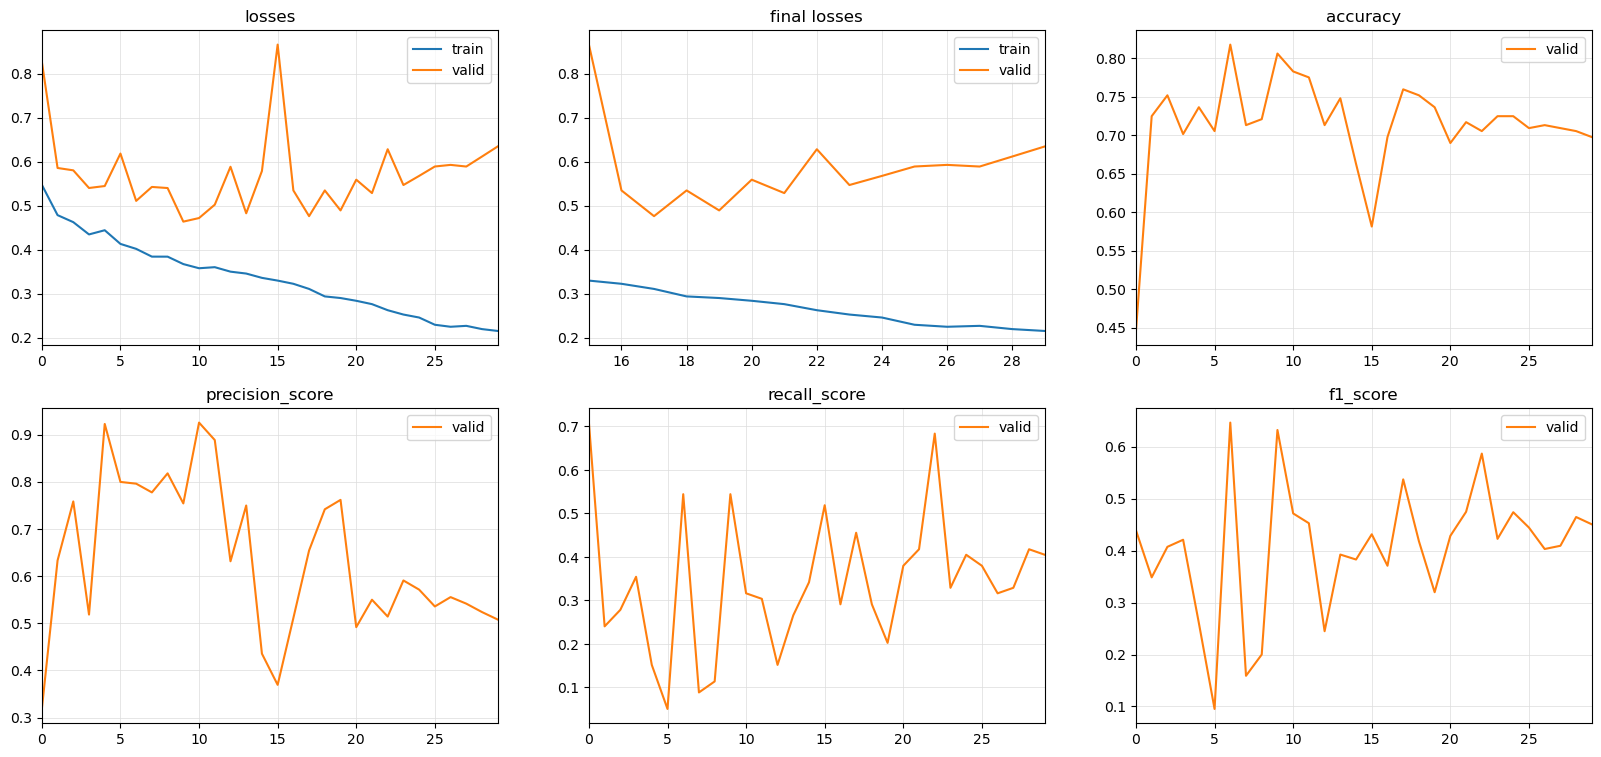

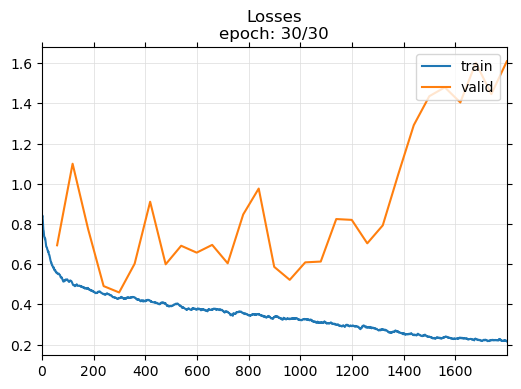

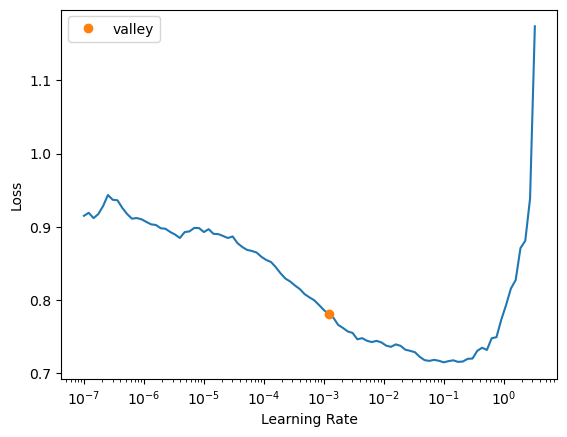

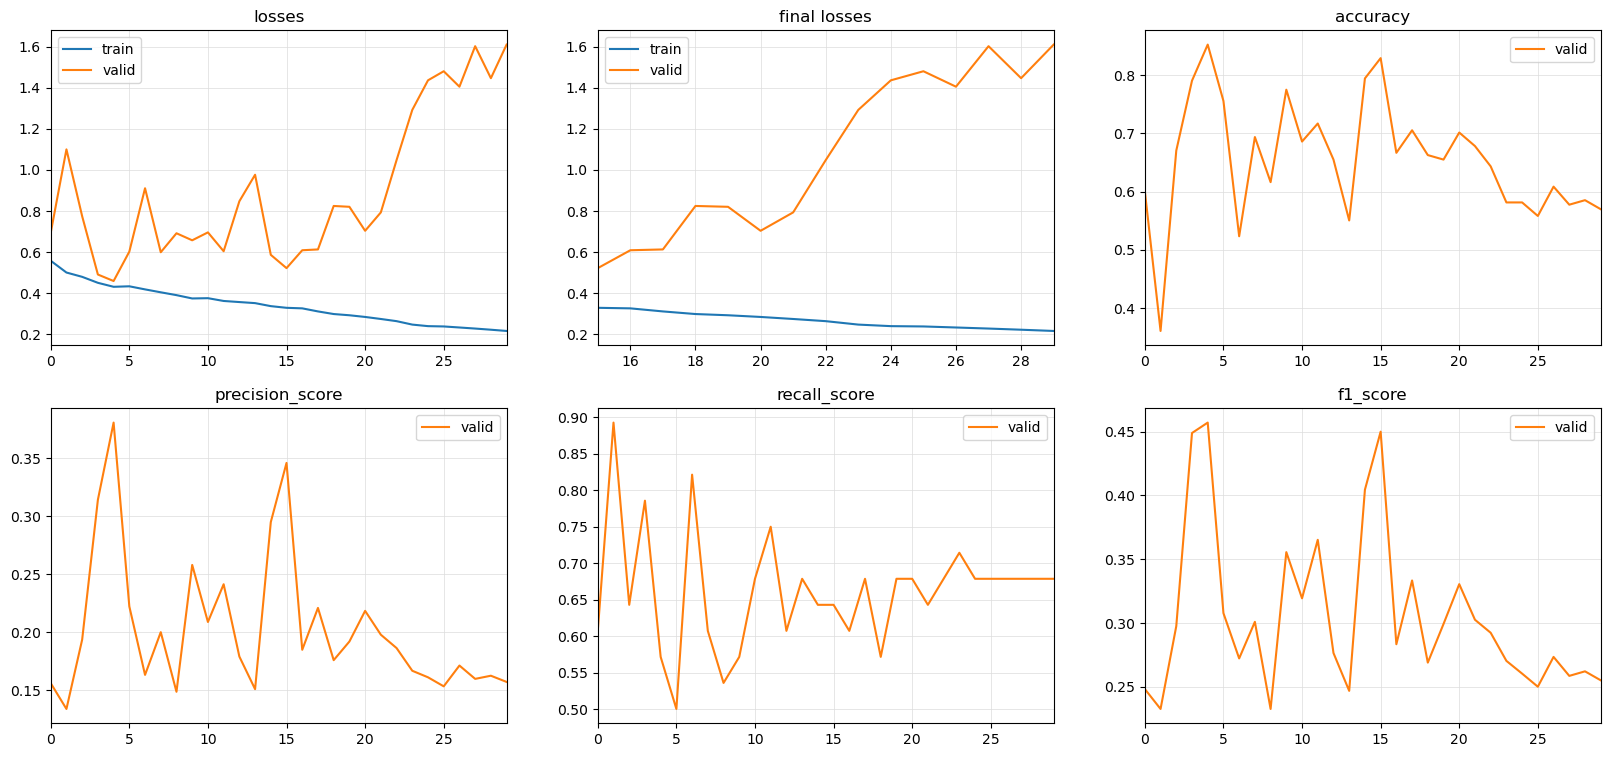

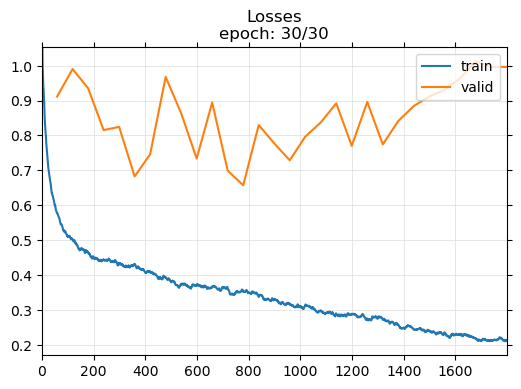

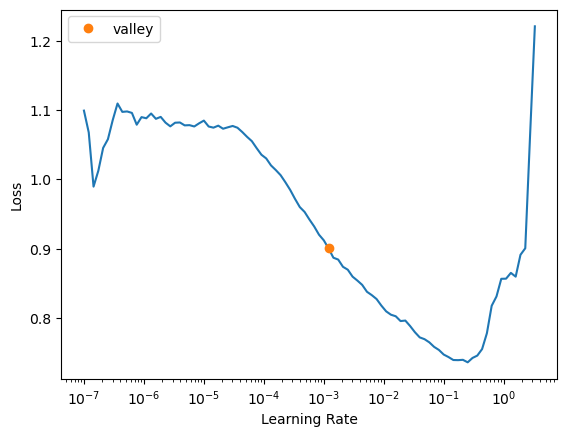

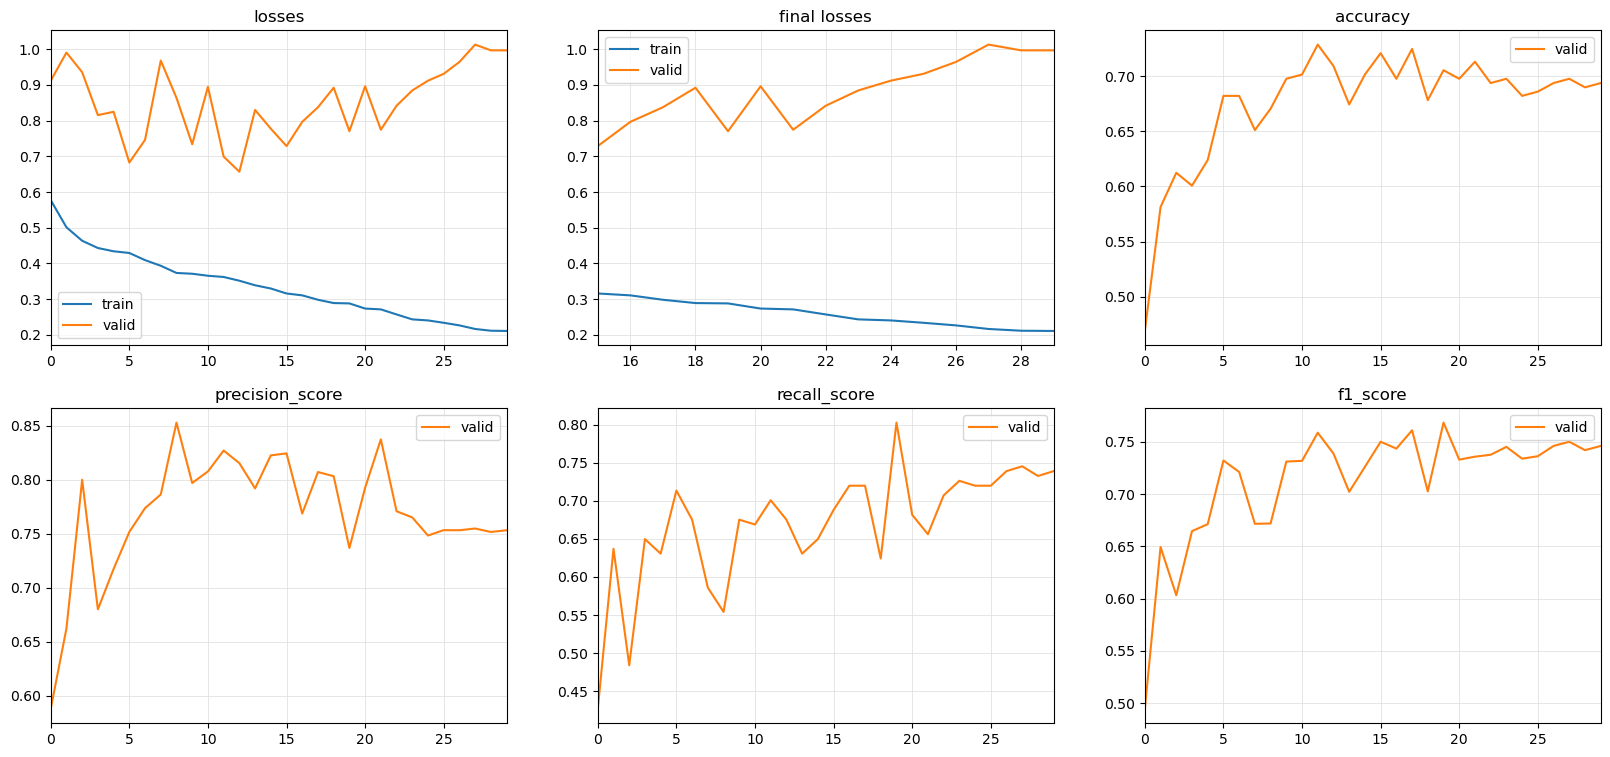

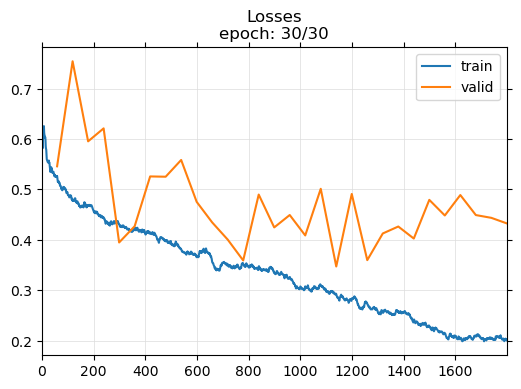

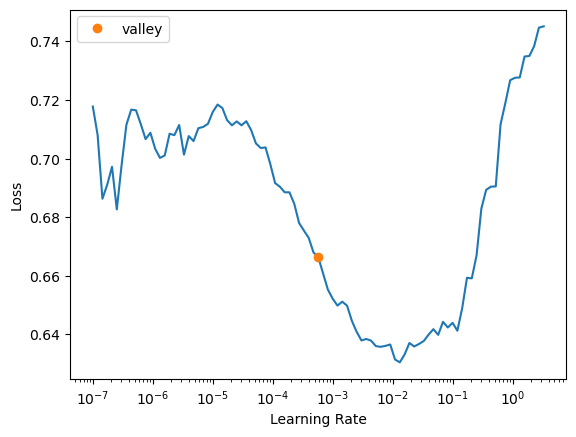

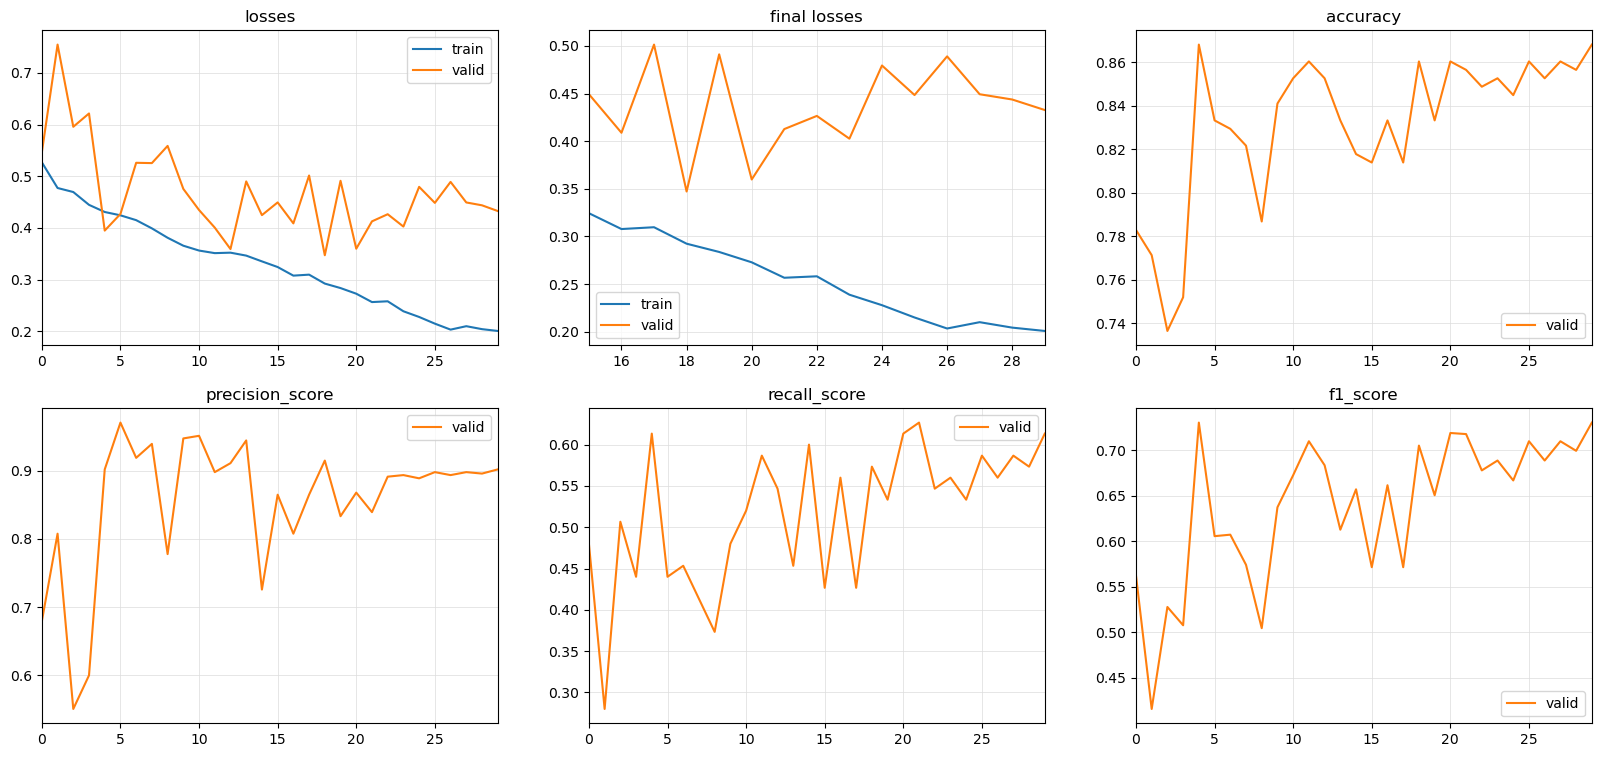

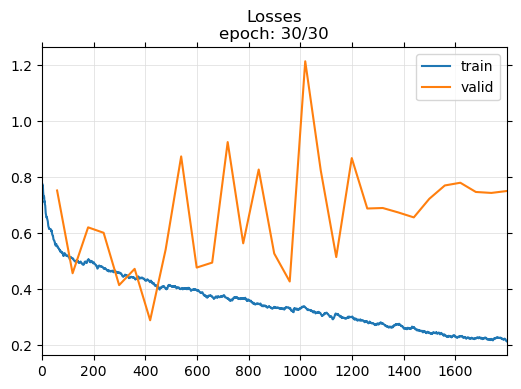

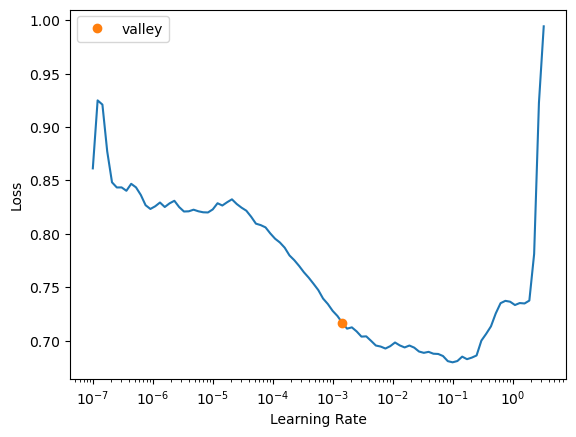

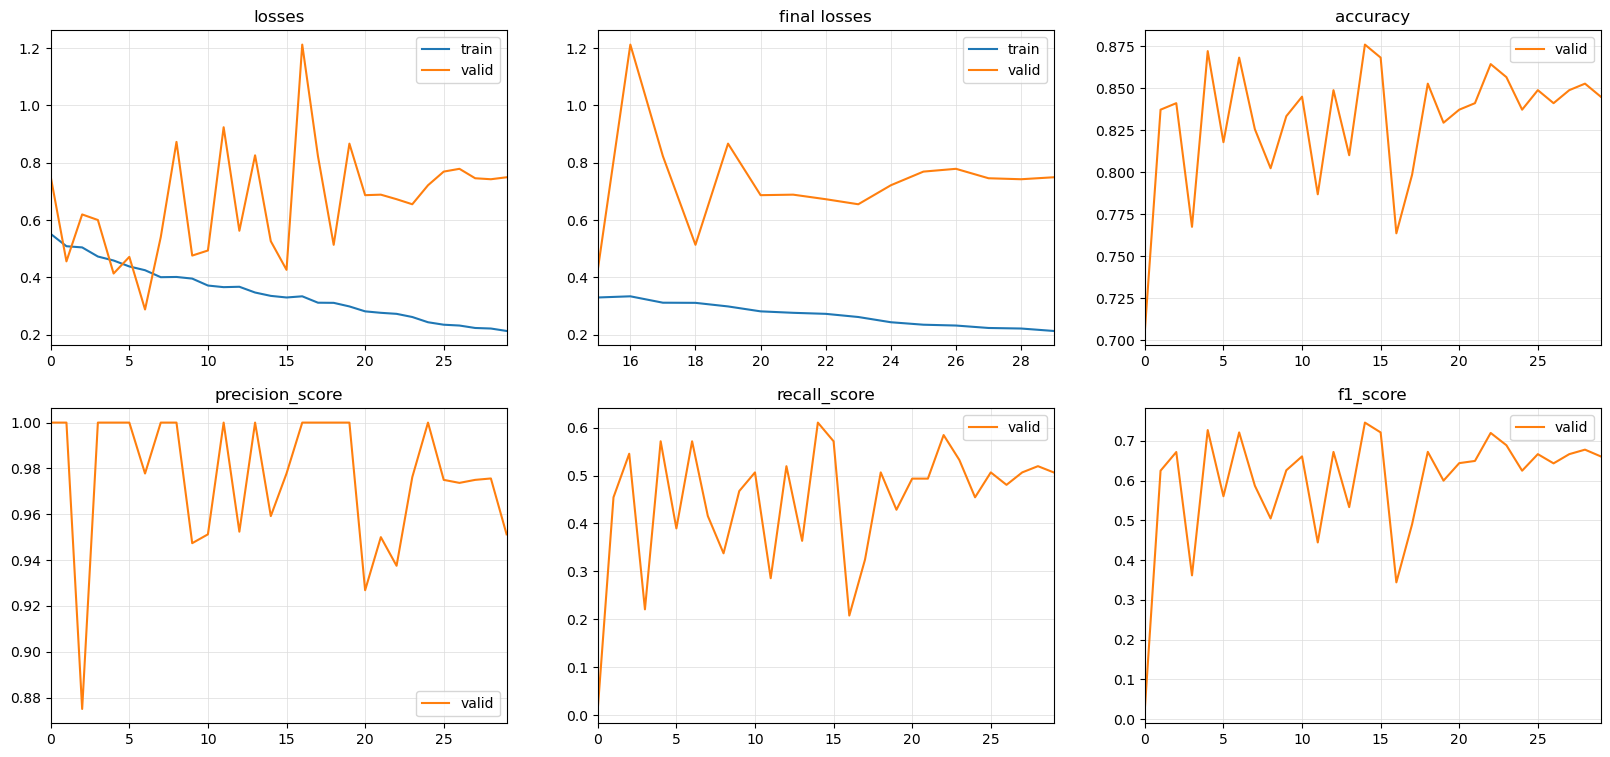

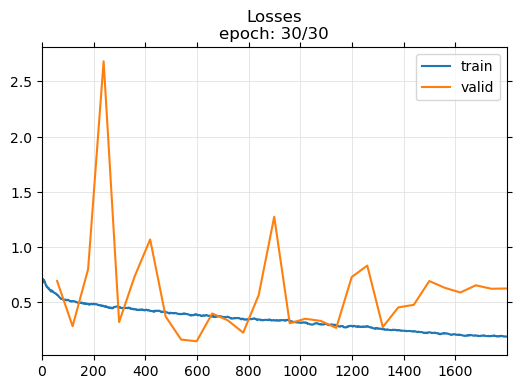

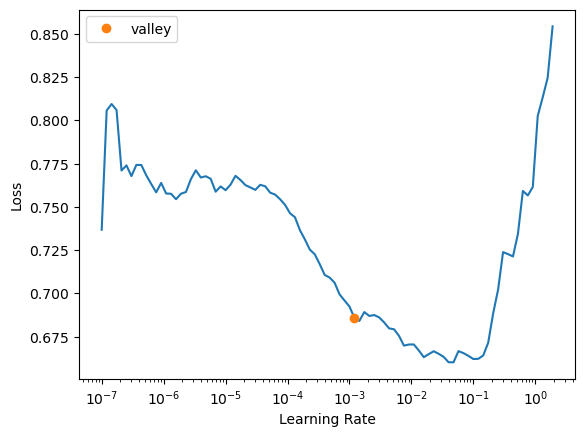

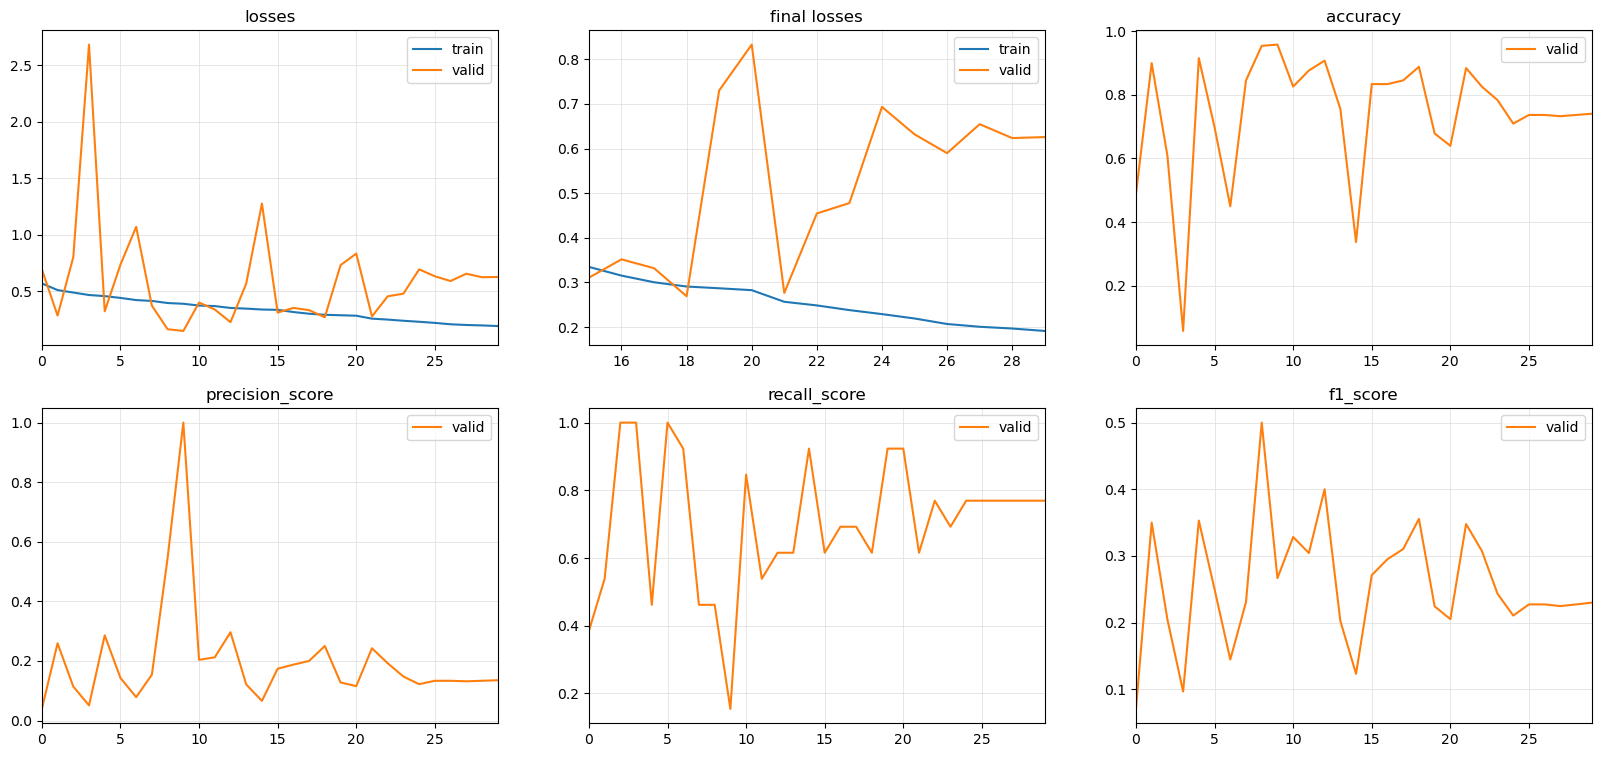

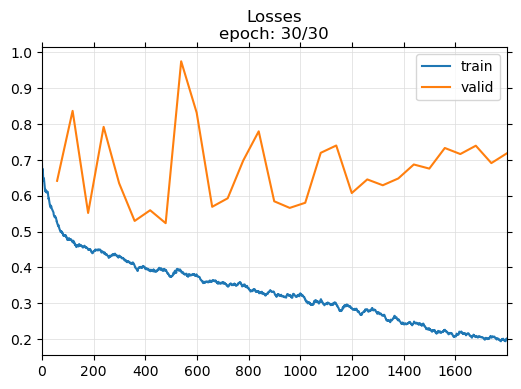

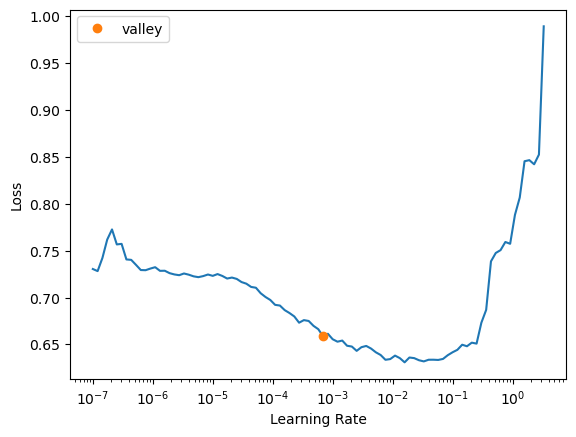

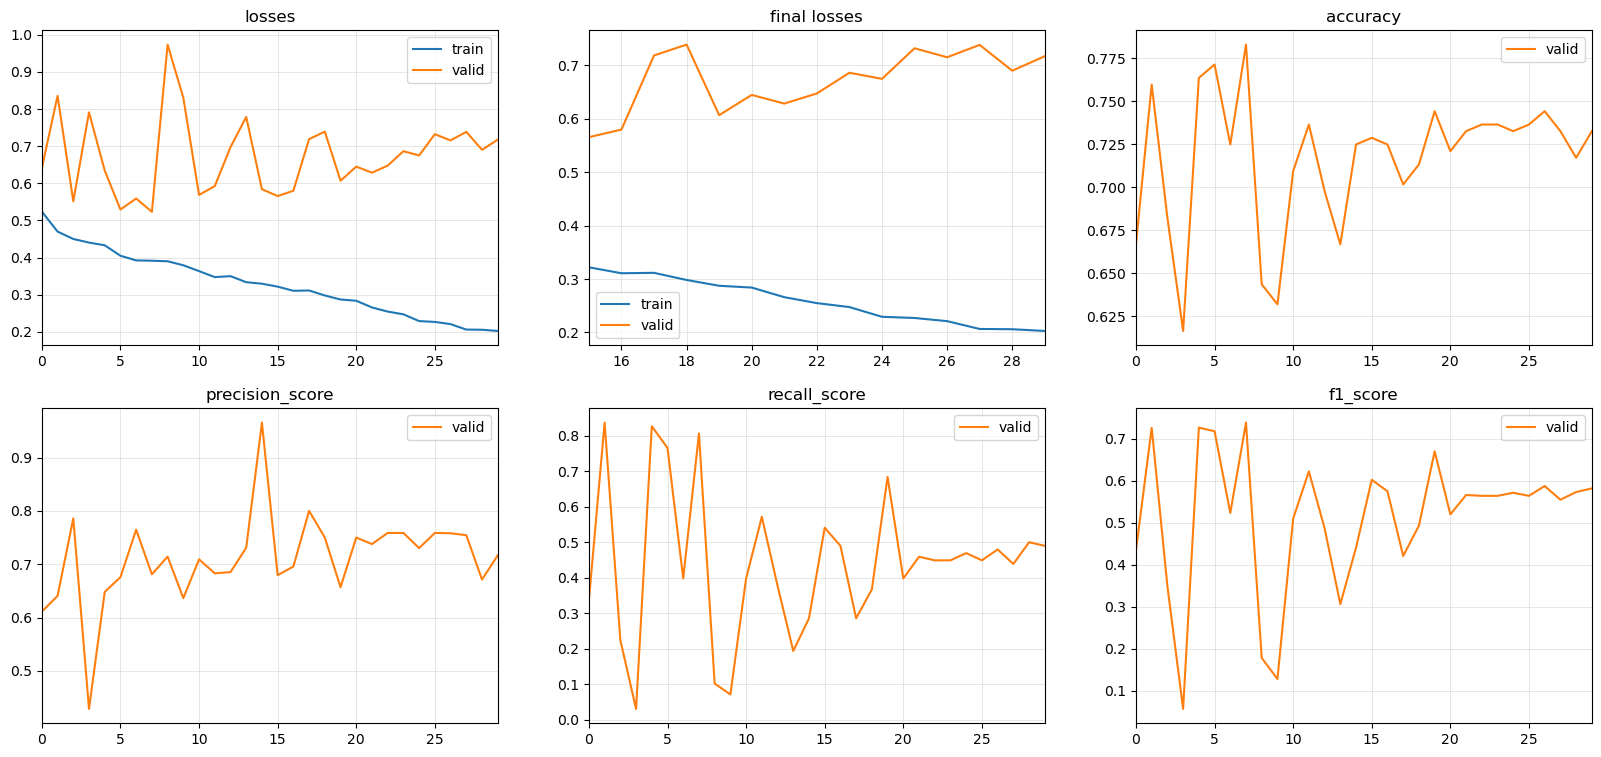

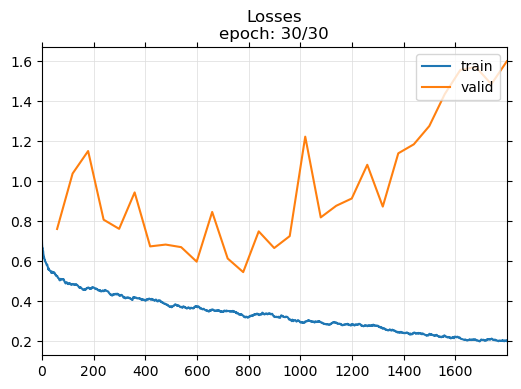

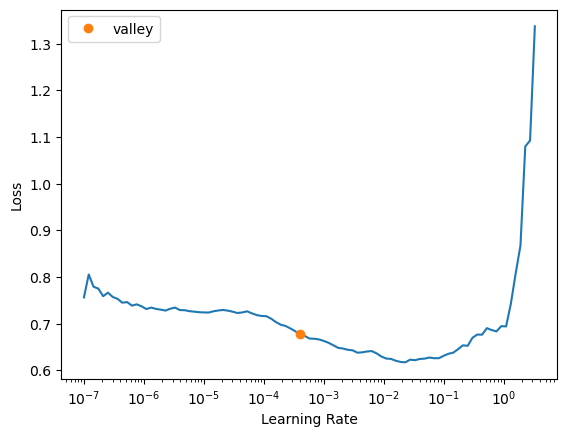

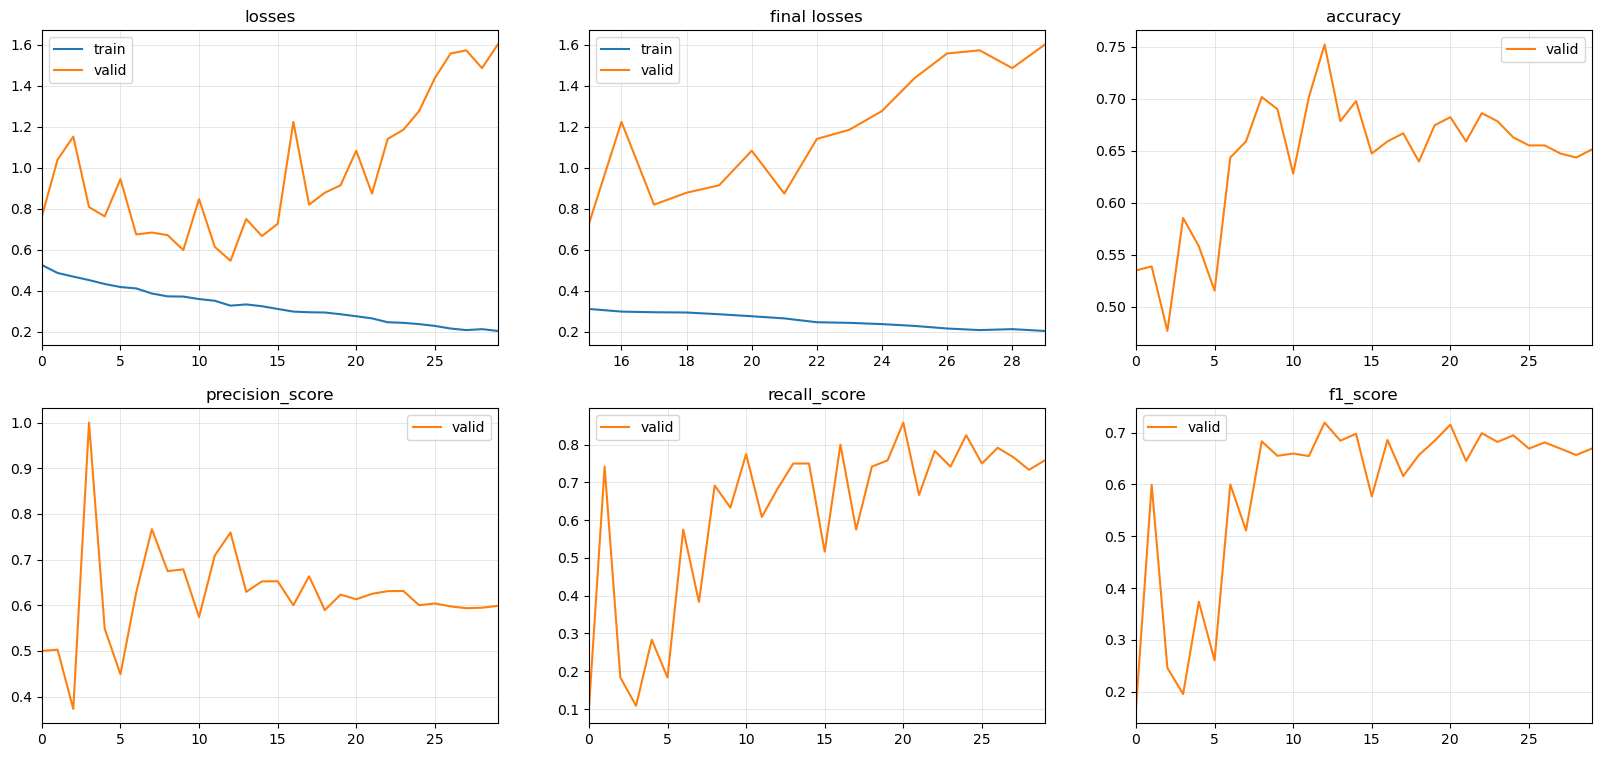

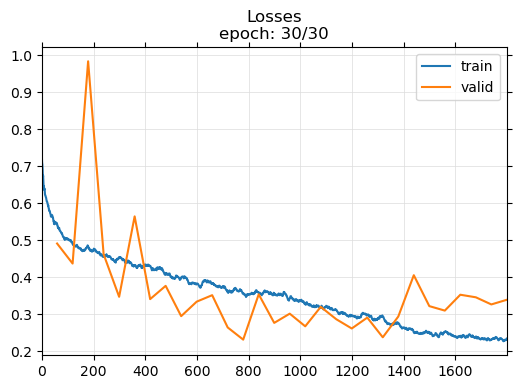

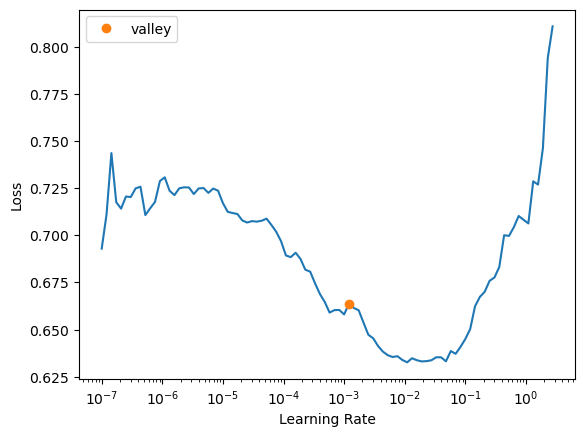

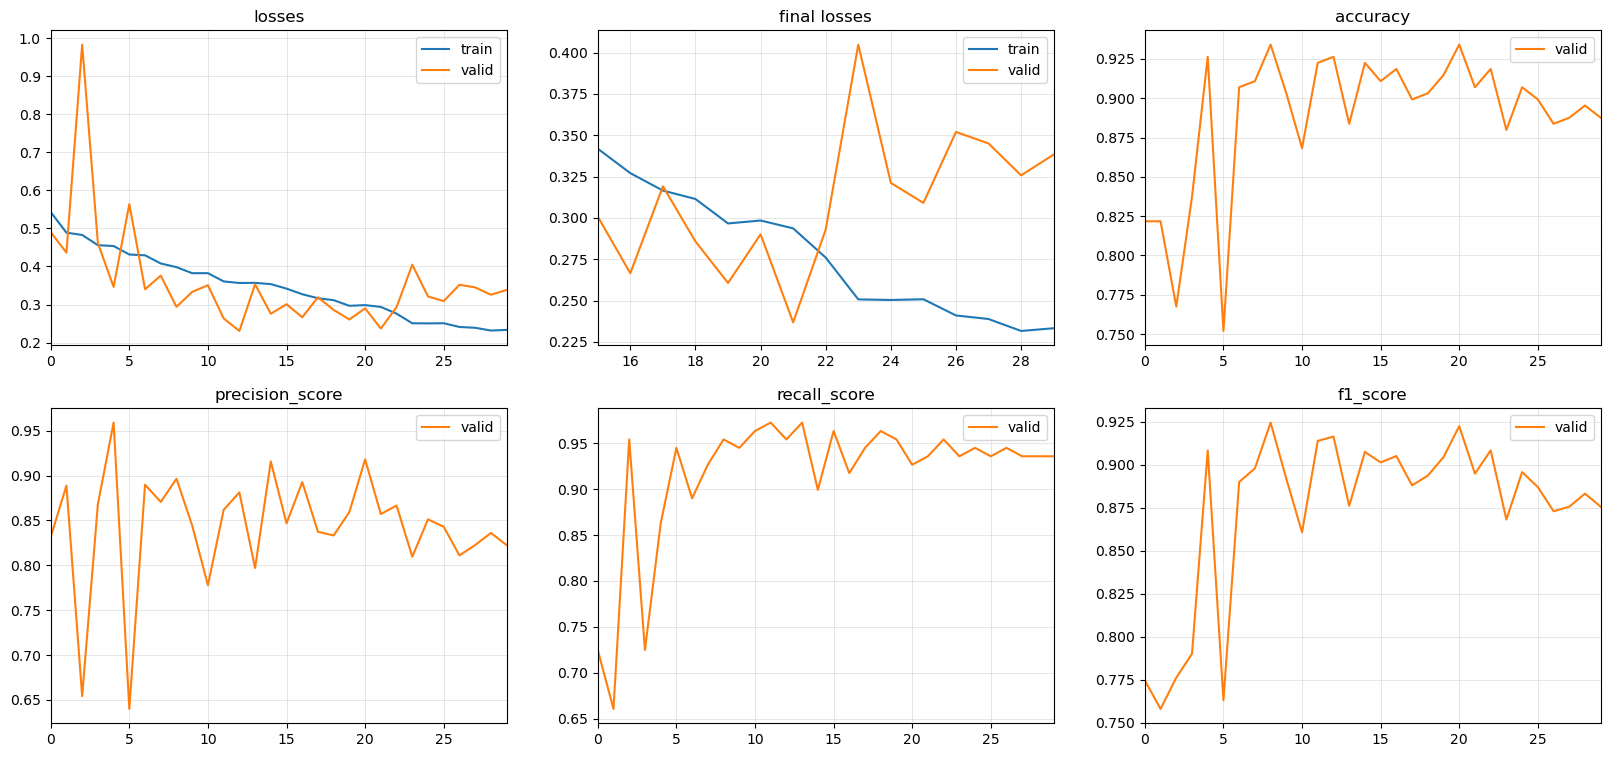

In [16]:
metrics = [accuracy, Precision(), Recall(), F1Score()]

def train_and_evaluate_it(X, y, splits, bs, lr, epochs):
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train,
                                   dsets.valid,
                                   bs=bs,
                                   batch_tfms=[TSStandardize()],
                                   num_workers=0)
    model = build_ts_model(InceptionTimePlus, dls=dls, **{'fc_dropout': 0.5})
    learn = ts_learner(dls, model, metrics=metrics, cbs=ShowGraph())
    learn.lr_find()
    learn.fit_one_cycle(epochs, lr_max=lr)


splits = get_splits(new_y,
                    n_splits=16,
                    shuffle=False,
                    stratify=True,
                    check_splits=True)

for s in splits:
    train_and_evaluate_it(X, new_y, s, [64, 128], 0.003, 30)

##### Save model

In [ ]:
# learn.save('all_features')

In [ ]:
# learn.save_all(path='export_all',
#                dls_fname='dls',
#                model_fname='model',
#                learner_fname='learner')

## Inferece


In [ ]:
# learn = load_learner_all(path='export_rmmsd',
#                          dls_fname='dls',
#                          model_fname='model',
#                          learner_fname='learner')

dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

In [ ]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

In [ ]:
(valid_targets == valid_preds).float().mean()

In [ ]:
learn.show_results()


In [ ]:
learn.show_probas()


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
# plot hypnogram of the predictions and the targets
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(valid_preds, label='Predictions')
ax.plot(valid_targets, label='Targets')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Sleep Stage')
ax.set_title('Predictions vs Targets')
plt.show()

In [ ]:
interp.most_confused(min_val=3)

In [ ]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

# inference on unseen data

In [ ]:
# Read the data
test_data = pd.read_csv('final_test_processed.csv', index_col=0)

test_data = test_data[test_data.sleep_state != -1]

# Binary Classification
test_data["sleep_state"] = np.where(test_data["sleep_state"] == 0, 0, 1)

# fill NaN values
test_data = test_data.fillna(method='bfill', limit=1500).dropna()

# # set column time as datetime index
# df['time'] = pd.to_datetime(df['time'])
# df = df.set_index('time', drop=True)

test_data = test_data[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]


# remove extreme values from the signal (outliers)
test_filtered_ppg = remove_extreme_values(test_data['ledGreen'], threshold=3.0)
test_filtered_bpm = remove_extreme_values(test_data['bpm'], threshold=3.0)
test_filtered_rmssd = remove_extreme_values(test_data['rmssd'], threshold=3.0)
test_filtered_pnn20 = remove_extreme_values(test_data['pnn20'], threshold=3.0)
test_filtered_pnn50 = remove_extreme_values(test_data['pnn50'], threshold=3.0)
test_filtered_hr_mad = remove_extreme_values(test_data['hr_mad'], threshold=3.0)
test_filtered_sd1 = remove_extreme_values(test_data['sd1'], threshold=3.0)
test_filtered_sd2 = remove_extreme_values(test_data['sd2'], threshold=3.0)
test_filtered_accelerometerX = remove_extreme_values(test_data['accelerometerX'],
                                                threshold=3.0)
test_filtered_accelerometerY = remove_extreme_values(test_data['accelerometerY'],
                                                threshold=3.0)
test_filtered_accelerometerZ = remove_extreme_values(test_data['accelerometerZ'],
                                                threshold=3.0)
test_filtered_gyroscopeX = remove_extreme_values(test_data['gyroscopeX'], threshold=3.0)
test_filtered_gyroscopeY = remove_extreme_values(test_data['gyroscopeY'], threshold=3.0)
test_filtered_gyroscopeZ = remove_extreme_values(test_data['gyroscopeZ'], threshold=3.0)

test_data['ledGreen'] = test_filtered_ppg
test_data['bpm'] = test_filtered_bpm
test_data['rmssd'] = test_filtered_rmssd
test_data['pnn20'] = test_filtered_pnn20
test_data['pnn50'] = test_filtered_pnn50
test_data['hr_mad'] = test_filtered_hr_mad
test_data['sd1'] = test_filtered_sd1
test_data['sd2'] = test_filtered_sd2
test_data['accelerometerX'] = test_filtered_accelerometerX
test_data['accelerometerY'] = test_filtered_accelerometerY
test_data['accelerometerZ'] = test_filtered_accelerometerZ
test_data['gyroscopeX'] = test_filtered_gyroscopeX
test_data['gyroscopeY'] = test_filtered_gyroscopeY
test_data['gyroscopeZ'] = test_filtered_gyroscopeZ

test_data = test_data.dropna()

plt.plot(test_filtered_ppg)

In [ ]:
test_data

In [ ]:
scaler = RobustScaler()
le = LabelEncoder()

X_test = scaler.fit_transform(test_data.drop('sleep_state', axis=1))
y_test = le.fit_transform(test_data['sleep_state'])

# selecting sequences range
X_test = X_test[0:(len(X_test) - len(X_test) % 1500)]
y_test = y_test[0:(len(y_test) - len(y_test) % 1500)]


In [ ]:
# reshape the data to tsai format
X_test = X_test.reshape(-1, 1500, 14)
X_test = X_test.transpose(0, 2, 1)
y_test = y_test.reshape(-1, 1500)
y_test = (y_test.sum(axis=1) // 1500).reshape(-1, 1).flatten()

print(X_test.shape, y_test.shape)

pd.DataFrame(X_test[0]).head()

In [ ]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(
    X_test)  # In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


In [ ]:
print(f'accuracy: {skm.accuracy_score(y_test, test_preds):10.6f}')

In [ ]:
learn.show_results()


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### If unlabelled data

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas
